## 예제 4-2 셰익스피어 작품의 문장 생성을 LSTM으로 학습하기

LSTM으로 셰익스피어 작품 흉내 내기를 실습한다. 모형은 입력층과 2개의 은닉층 그리고 출력층으로 구성된다. 은닉층의 노드 수는 32, 서열 길이는 50, 가중치 클리핑은 5로 설정하였다.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [131]:
#-------------------------------------------------
# 데이터 불러오기
#-------------------------------------------------
raw_data = open('./input.txt', 'r').read() # input.txt 예제 데이터

In [132]:
print(len(raw_data))

1115394


In [69]:
# 계산 시간 때문에 일부만 사용
raw_data = raw_data[:200000]

In [133]:
print(type(raw_data))
print(len(raw_data))
print(raw_data[0:100])

<class 'str'>
1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [134]:
# 전체 문자 수
n_samples = len(raw_data)
# 고유한 문자
unique_chars = list(set(raw_data));
# 문자를 정수로 변환하는 딕셔너리
char_to_int = { ch:i for i,ch in enumerate(unique_chars) }
# 정수를 문자로 변환하는 딕셔너리
int_to_char = { i:ch for i,ch in enumerate(unique_chars) }
# 고유한 문자 수
n_unique_chars = len(unique_chars)

In [135]:
print(n_samples)
print(n_unique_chars)

1115394
65


In [136]:
# 입력층의 노드 수(입력 크기) = 원-핫 벡터 크기
input_dim = n_unique_chars
# 출력층의 노드 수 = 고유한 문자 수
num_classes = n_unique_chars

In [137]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 32
# 미니배치 크기: 100
# 반복 수: 200
# 학습률: 0.1
# Gradient Clipping에 사용할 임곗값: 2
batch_size = 100
seq_len = 50 # 한 번에 입력되는 서열 길이
hidden_size = 32 # 은닉층 노드 수
learning_rate = 0.05
grad_clip = 5 # Gradient Clipping에 사용할 임곗값
nepochs = 50 # 반복 수
# 배치 개수
num_batches = int(len(raw_data)/(batch_size * seq_len)) # 40

In [138]:
# 데이터 - (배치 크기*배치 개수)
data = raw_data[:num_batches*batch_size*seq_len]
# 데이터를 정수로 변환
data = np.array([char_to_int[n] for n in data]);

In [139]:
# 입력과 목표 데이터 설정
xdata = data
ydata = np.copy(data)
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]

In [140]:
# 배치 개수*배치 크기*서열 길이 = (?, 100, 32)
#x_batches = np.split(xdata.reshape(batch_size, -1),num_batches, 1)
#x_batches = np.asarray(x_batches)
#x_batches.shape
dataset = tf.data.Dataset.from_tensor_slices((xdata, ydata)).batch(seq_len, drop_remainder=True)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [141]:
print(type(dataset))
print(dataset)
print(list(dataset.as_numpy_iterator())[0])

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((100, 50), (100, 50)), types: (tf.int32, tf.int32)>
(array([[40, 47, 33, ..., 12,  2, 33],
       [27,  7, 12, ...,  4, 52, 30],
       [27,  2, 33, ..., 61, 61, 50],
       ...,
       [47, 39,  0, ..., 25, 52, 30],
       [34, 61, 61, ..., 12, 27,  8],
       [47,  0, 39, ..., 12, 63, 63]]), array([[47, 33, 17, ...,  2, 33, 27],
       [ 7, 12, 27, ..., 52, 30, 27],
       [ 2, 33, 12, ..., 61, 50, 63],
       ...,
       [39,  0, 27, ..., 52, 30, 34],
       [61, 61, 40, ..., 27,  8, 47],
       [ 0, 39, 63, ..., 63, 63, 52]]))


In [79]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(n_unique_chars, hidden_size))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
#model.add(tf.keras.layers.LSTM(hidden_size))
model.add(tf.keras.layers.Dense(n_unique_chars))

In [66]:
for layer in model.layers:
    print("layer: ", layer.name, " | input shape: ", layer.input.shape, " | output shape: ", layer.output.shape, )

layer:  embedding_6  | input shape:  (None, None)  | output shape:  (None, None, 32)
layer:  spatial_dropout1d_6  | input shape:  (None, None, 32)  | output shape:  (None, None, 32)
layer:  lstm_18  | input shape:  (None, None, 32)  | output shape:  (None, None, 32)
layer:  lstm_19  | input shape:  (None, None, 32)  | output shape:  (None, None, 32)
layer:  lstm_20  | input shape:  (None, None, 32)  | output shape:  (None, None, 32)
layer:  dense_6  | input shape:  (None, None, 32)  | output shape:  (None, None, 62)


In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          1984      
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
dense_6 (Dense)              (None, None, 62)          2046      
Total params: 28,990
Trainable params: 28,990
Non-trainable params: 0
__________________________________________________

In [68]:
def loss(labels, predictions):
    return tf.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)

In [69]:
#model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy')
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate, clipvalue=grad_clip), loss=loss)

In [70]:
steps_per_epoch = n_samples // seq_len // batch_size # 200000 / 100 / 50 = 40
#history = model.fit(dataset.repeat(), epochs=nepochs, steps_per_epoch=steps_per_epoch)
history = model.fit(dataset.repeat(), epochs=100, steps_per_epoch=steps_per_epoch)

Train for 40 steps
Epoch 1/100
40/40 [==============================] - 4s 109ms/step - loss: 3.2582
Epoch 2/100
40/40 [==============================] - 1s 26ms/step - loss: 2.7748
Epoch 3/100
40/40 [==============================] - 1s 26ms/step - loss: 2.5527
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 2.4547
Epoch 5/100
40/40 [==============================] - 1s 26ms/step - loss: 2.3689
Epoch 6/100
40/40 [==============================] - 1s 26ms/step - loss: 2.3035
Epoch 7/100
40/40 [==============================] - 1s 26ms/step - loss: 2.2498
Epoch 8/100
40/40 [==============================] - 1s 26ms/step - loss: 2.2049
Epoch 9/100
40/40 [==============================] - 1s 26ms/step - loss: 2.1728
Epoch 10/100
40/40 [==============================] - 1s 26ms/step - loss: 2.1432
Epoch 11/100
40/40 [==============================] - 1s 26ms/step - loss: 2.1082
Epoch 12/100
40/40 [==============================] - 1s 26ms/step - loss: 2.0907
Epoch

Text(0, 0.5, 'Losses')

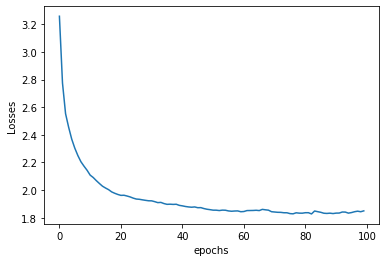

In [72]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [96]:
# 생성할 문장의 길이
generated_text_len = 200  
# 시작 문자를 't'로 지정.
generated_text = 't' 

In [97]:
# RNN의 최초 state값을 0으로 초기화.
#state = sess.run(cell.zero_state(1, tf.float32))
model.reset_states()

In [100]:
text_generated = []
input = [char_to_int[s] for s in generated_text]
input = tf.expand_dims(input, 0)
for i in range(generated_text_len):
    preds = model(input)
    # 차원이 1인 차원을 모두 제거한다
    preds = tf.squeeze(preds, 0)
    # predict char returned by model
    pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
    text_generated.append(int_to_char[pred_id])
    # pass the prediction as the next input to the model
    input = tf.expand_dims([pred_id], 0)

In [101]:
print(generated_text + "".join(text_generated))

t ot mns oito te t'R:
Gut ower, n, alfemhelit, an os
GLAn'sur rgee'd, mer d
Whe, n's re,-sareneres ve t o cus, ado, d b, lesongesuvinldthe ten a sal ard tr l do I R:

Qut io d,
S: d hee mef d band f s 


## 예제 4-2 셰익스피어 작품의 문장 생성을 LSTM으로 학습하기 (using stateful and entire data)

LSTM으로 셰익스피어 작품 흉내 내기를 실습한다. 모형은 입력층과 2개의 은닉층 그리고 출력층으로 구성된다. 은닉층의 노드 수는 32, 서열 길이는 50, 가중치 클리핑은 5로 설정하였다.

In [104]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [142]:
#-------------------------------------------------
# 데이터 불러오기
#-------------------------------------------------
raw_data = open('./input.txt', 'r').read() # input.txt 예제 데이터

In [143]:
print(len(raw_data))

1115394


In [107]:
# 계산 시간 때문에 일부만 사용
raw_data = raw_data[:200000]

In [144]:
print(type(raw_data))
print(len(raw_data))
print(raw_data[0:100])

<class 'str'>
1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [145]:
# 전체 문자 수
n_samples = len(raw_data)
# 고유한 문자
unique_chars = list(set(raw_data));
# 문자를 정수로 변환하는 딕셔너리
char_to_int = { ch:i for i,ch in enumerate(unique_chars) }
# 정수를 문자로 변환하는 딕셔너리
int_to_char = { i:ch for i,ch in enumerate(unique_chars) }
# 고유한 문자 수
n_unique_chars = len(unique_chars)

In [146]:
print(n_samples)
print(n_unique_chars)

1115394
65


In [147]:
# 입력층의 노드 수(입력 크기) = 원-핫 벡터 크기
input_dim = n_unique_chars
# 출력층의 노드 수 = 고유한 문자 수
num_classes = n_unique_chars

In [148]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 32
# 미니배치 크기: 100
# 반복 수: 200
# 학습률: 0.1
# Gradient Clipping에 사용할 임곗값: 2
batch_size = 100
seq_len = 50 # 한 번에 입력되는 서열 길이
hidden_size = 32 # 은닉층 노드 수
learning_rate = 0.05
grad_clip = 5 # Gradient Clipping에 사용할 임곗값
nepochs = 50 # 반복 수
# 배치 개수
num_batches = int(len(raw_data)/(batch_size * seq_len)) # 40

In [149]:
# 데이터 - (배치 크기*배치 개수)
data = raw_data[:num_batches*batch_size*seq_len]
# 데이터를 정수로 변환
data = np.array([char_to_int[n] for n in data]);

In [150]:
# 입력과 목표 데이터 설정
xdata = data
ydata = np.copy(data)
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]

In [151]:
# 배치 개수*배치 크기*서열 길이 = (?, 100, 32)
#x_batches = np.split(xdata.reshape(batch_size, -1),num_batches, 1)
#x_batches = np.asarray(x_batches)
#x_batches.shape
dataset = tf.data.Dataset.from_tensor_slices((xdata, ydata)).batch(seq_len, drop_remainder=True)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [152]:
print(type(dataset))
print(dataset)
print(list(dataset.as_numpy_iterator())[0])

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((100, 50), (100, 50)), types: (tf.int32, tf.int32)>
(array([[40, 47, 33, ..., 12,  2, 33],
       [27,  7, 12, ...,  4, 52, 30],
       [27,  2, 33, ..., 61, 61, 50],
       ...,
       [47, 39,  0, ..., 25, 52, 30],
       [34, 61, 61, ..., 12, 27,  8],
       [47,  0, 39, ..., 12, 63, 63]]), array([[47, 33, 17, ...,  2, 33, 27],
       [ 7, 12, 27, ..., 52, 30, 27],
       [ 2, 33, 12, ..., 61, 50, 63],
       ...,
       [39,  0, 27, ..., 52, 30, 34],
       [61, 61, 40, ..., 27,  8, 47],
       [ 0, 39, 63, ..., 63, 63, 52]]))


In [167]:
class CharGenModel(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, **kwargs):
        super(CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding(n_unique_chars, hidden_size)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn_layer_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True)
        self.rnn_layer_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True)
        self.rnn_layer_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True)
        self.dense_layer = tf.keras.layers.Dense(n_unique_chars)
        
    def call(self, x):
        x = self.embedding_layer(x)
        x = self.dropout(x)
        x = self.rnn_layer_1(x)
        x = self.rnn_layer_2(x)
        x = self.rnn_layer_3(x)
        x = self.dense_layer(x)
        return x

In [168]:
model = CharGenModel(n_unique_chars, seq_len, hidden_size)
model.build(input_shape=(batch_size, seq_len))

In [169]:
model.summary()

Model: "char_gen_model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  2080      
_________________________________________________________________
spatial_dropout1d_14 (Spatia multiple                  0         
_________________________________________________________________
lstm_42 (LSTM)               multiple                  8320      
_________________________________________________________________
lstm_43 (LSTM)               multiple                  8320      
_________________________________________________________________
lstm_44 (LSTM)               multiple                  8320      
_________________________________________________________________
dense_14 (Dense)             multiple                  2145      
Total params: 29,185
Trainable params: 29,185
Non-trainable params: 0
_____________________________________________

In [170]:
def loss(labels, predictions):
    return tf.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)

In [171]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate, clipvalue=grad_clip), loss=loss)

In [172]:
steps_per_epoch = n_samples // seq_len // batch_size # 200000 / 100 / 50 = 40
print(steps_per_epoch)

223


In [173]:
history = model.fit(dataset.repeat(), epochs=nepochs, steps_per_epoch=steps_per_epoch)

Train for 223 steps
Epoch 1/50
223/223 [==============================] - 18s 80ms/step - loss: 2.6839
Epoch 2/50
223/223 [==============================] - 15s 66ms/step - loss: 2.3044
Epoch 3/50
223/223 [==============================] - 15s 67ms/step - loss: 2.1993
Epoch 4/50
223/223 [==============================] - 15s 67ms/step - loss: 2.1561
Epoch 5/50
223/223 [==============================] - 15s 67ms/step - loss: 2.1280
Epoch 6/50
223/223 [==============================] - 15s 67ms/step - loss: 2.1057
Epoch 7/50
223/223 [==============================] - 15s 66ms/step - loss: 2.0843
Epoch 8/50
223/223 [==============================] - 15s 68ms/step - loss: 2.0702
Epoch 9/50
223/223 [==============================] - 15s 69ms/step - loss: 2.0594
Epoch 10/50
223/223 [==============================] - 16s 70ms/step - loss: 2.0514
Epoch 11/50
223/223 [==============================] - 15s 67ms/step - loss: 2.0462
Epoch 12/50
223/223 [==============================] - 15s 67ms/s

Text(0, 0.5, 'Losses')

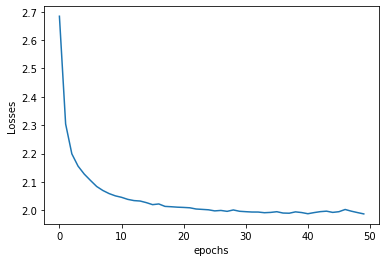

In [174]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [175]:
# 생성할 문장의 길이
generated_text_len = 1000  
# 시작 문자를 't'로 지정.
generated_text = 't'

In [176]:
CHECKPOINT_DIR = os.path.join("data", "checkpoints") # where we will save the weights
checkpoint_file = os.path.join(CHECKPOINT_DIR, 'char_gen_model')
model.save_weights(checkpoint_file)

In [ ]:
gen_model = CharGenModel(n_unique_chars, seq_len, hidden_size)
gen_model.load_weights(checkpoint_file)
gen_model.build(input_shape=(1, seq_len))
gen_model.reset_states()

In [187]:
text_generated = []
input = [char_to_int[s] for s in generated_text]
input = tf.expand_dims(input, 1)
for i in range(generated_text_len):
    preds = gen_model(input)
    # 차원이 1인 차원을 모두 제거한다
    preds = tf.squeeze(preds, 0)
    # predict char returned by model
    pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
    text_generated.append(int_to_char[pred_id])
    # pass the prediction as the next input to the model
    input = tf.expand_dims([pred_id], 0)
    
print(generated_text + "".join(text_generated))

t
Her of thou ne wor.

Luest:
Hoshish Pome
As is the vixe.

PENSENTE:
And these resters of dow not brt thombn bedringer woors leathors trron? yewt light; elis the with sean your raon worl the filler, geathle as wille to to got the knlosge be, bothoil with my doot is
In wad mher to farg by keem bees,
Whipe, anllar an esdeews n speimge it so nond Be'
to hather.
I,
They gather wofore bid come thing! but at joth inst;
The puitherft 
Andent Kangy more he no deslan that he you show of a bove for the reather
Besent.
And. I sprans? and fie.'
My

The goid trord'd spant to your not Oily; youd, uplore his whenten so huths agored.

Fnow:
War my ost's that loace, we dare
Thy
I fh in me
A
this the swell!

BETRUCHIO:
For, lock!

Grorst: them ofl.

PETRUCHIO:
By le's groma, un casen his arherr puer, aran on all suor.

GOPA:
To nom stabnattto: the partter that melirm abowg lidomed
sill dirtore of the fapblescio.'

Goikgt Kenedart zingpy:
His lorcitas
I'lliompeatan and raynend here oolfer:
Arbucher the 

## 예제 4-3 AR(2) 모형 학습하기

이번에는 AR(2) 모형을 따르는 시계열을 예측하는 예제를 다룬다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#--------------------------------------------------
# 길이가 100인 data(#AR(2) with a1=0.5; a2=-0.3) 만들기
#--------------------------------------------------
k=100
x=np.random.normal(0,1,k); 
e=np.random.normal(0,1,k)
a1=0.5 
a2=-0.3

x[2]=a1*x[1]+a2*x[0]+e[2]
for i in range(2,k):
    x[i]=a1*x[i-1]+a2*x[i-2]+e[i]

# 표준화    
x=(x-min(x))/(max(x)-min(x))

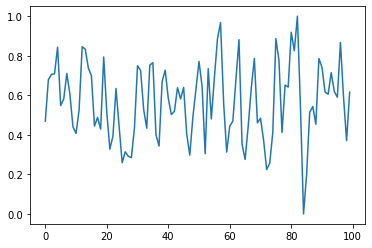

In [3]:
plt.plot(x)

In [4]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 16
# 미니배치 크기: 1
# 반복 수: 1000
# 학습률 :0.0005
# 서열길이 10
hidden_size =16 
learning_rate = 0.0005 
nepochs = 1000 
seq_len=10 
batch_size=1

In [5]:
#------------------------------------------
# 시계열 훈련에 적합한 데이터 만들기
# 0~9 : input, 10: target
# 1~10 : input, 11: target
# ...
# 89~98 : input, 99: target
#-------------------------------------------
dataX = []; dataY = []
for i in range(k-seq_len):
    tempX=x[i:i+seq_len]
    dataX.append(tempX)
    tempY=x[i+seq_len]
    dataY.append(tempY)

In [6]:
print(len(dataX)) # (90, 10)
print(len(dataY)) # (90, 1)
print(dataX[0])
print(dataY[0])
print(dataX[1])
print(dataY[1])

90
90
[0.46937678 0.678638   0.70595934 0.70866806 0.84377514 0.54845276
 0.58144987 0.71020056 0.60577893 0.44079241]
0.4072385006651737
[0.678638   0.70595934 0.70866806 0.84377514 0.54845276 0.58144987
 0.71020056 0.60577893 0.44079241 0.4072385 ]
0.5269757293876081


In [7]:
# 데이터를 3차원으로 만듬
dataX = [x.reshape(seq_len, 1) for x in dataX] # (90, 10, 1)
dataY = [y.reshape(1,1) for y in dataY]  # (10, 1)

In [9]:
# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((dataX, dataY))

In [22]:
# 훈련 데이터와 테스트 데이터로 분리
train_size = 70
test_size = 20
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True) # (70, 10, 1)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True) # (20, 10, 1)

In [24]:
print(train_dataset)

<BatchDataset shapes: ((1, 10, 1), (1, 1, 1)), types: (tf.float64, tf.float64)>


In [12]:
print(list(train_dataset)[0])

(<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.46937678],
       [0.678638  ],
       [0.70595934],
       [0.70866806],
       [0.84377514],
       [0.54845276],
       [0.58144987],
       [0.71020056],
       [0.60577893],
       [0.44079241]])>, <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.4072385]])>)


In [55]:
# 훈련자료 크기    
sample_size=np.array(dataY).shape[0] # 90
print(sample_size)

90


In [10]:
# 플레이스 홀더
#X = tf.placeholder(tf.float32, shape=[None,seq_len,1])  # (None, 10, 1)
#Y = tf.placeholder(tf.float32, [None,1])                # (None, 1)

# 가중치와 편의 변수 
#W = tf.Variable(tf.random_normal([hidden_size, 1]))     # (16, 1)
#b = tf.Variable(tf.random_normal([1]))                  # (1)

# LSTM 셀 정의 
#cell1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)       # (16)
#cell2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)       # (16)
# 은닉층 2개
#multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
#output0, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)  

# 서열의 마지막 출력 값
#output1 = tf.transpose(output0, [1, 0, 2]); 
#outputs = output1[-1]   
#Y_pred= tf.matmul(outputs, W) + b


In [25]:
# 모델 생성
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size))
model.add(tf.keras.layers.Dense(1, activation=None))

In [26]:
# input shape 설정
model.build(input_shape=(batch_size, seq_len, 1))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                multiple                  1152      
_________________________________________________________________
lstm_3 (LSTM)                multiple                  2112      
_________________________________________________________________
dense_1 (Dense)              multiple                  17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 손실함수와 옵티마이저
#cost = tf.reduce_sum(tf.square(Y_pred - Y))  
#optim = tf.train.AdamOptimizer(learning_rate).minimize(cost)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='MSE')

In [29]:
# 50 epoch마다 학습과정을 출력하기 위해 callback 함수 생성
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print("epoch: ", epoch, ", loss: ", round(logs['loss'], 5)) if epoch%50 == 0 else None
)

In [30]:
#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
model.fit(train_dataset, epochs=nepochs, callbacks=[callback], verbose=0)

epoch:  0 , loss:  0.16084
epoch:  50 , loss:  0.0366
epoch:  100 , loss:  0.035
epoch:  150 , loss:  0.02604
epoch:  200 , loss:  0.02437
epoch:  250 , loss:  0.02261
epoch:  300 , loss:  0.02142
epoch:  350 , loss:  0.02011
epoch:  400 , loss:  0.01701
epoch:  450 , loss:  0.01135
epoch:  500 , loss:  0.00619
epoch:  550 , loss:  0.00354
epoch:  600 , loss:  0.00178
epoch:  650 , loss:  0.00239
epoch:  700 , loss:  0.00028
epoch:  750 , loss:  0.00021
epoch:  800 , loss:  0.00023
epoch:  850 , loss:  0.00338
epoch:  900 , loss:  0.00038
epoch:  950 , loss:  4e-05


In [41]:
# 훈련에 사용되지 않은 20개와 사용된 30개에 대한 예측
pred_dataset = train_dataset.skip(40).concatenate(test_dataset) # 훈련 데이터 끝 30개와 테스트 데이터 20개를 합침

In [43]:
print(len(list(pred_dataset)))
print(pred_dataset)

50
<ConcatenateDataset shapes: ((1, 10, 1), (1, 1, 1)), types: (tf.float64, tf.float64)>


In [52]:
# 예측값 생성
prediction = model.predict(pred_dataset)

In [53]:
print(prediction.shape)
print(prediction[0:10])

(50, 1)
[[0.780345  ]
 [0.6466387 ]
 [0.31450632]
 [0.7544555 ]
 [0.48441875]
 [0.6902306 ]
 [0.8931378 ]
 [0.9595697 ]
 [0.5800881 ]
 [0.320546  ]]


Text(0.5, 1.0, '1-step ahead prediction based on 10 previous data')

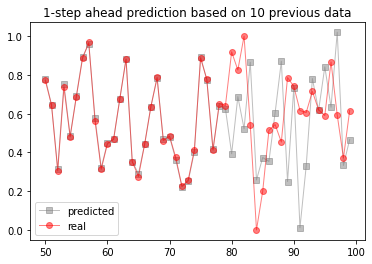

In [80]:
# 예측 결과 그림
b=np.array(prediction).shape[0]  
plt.plot(range(50, 50+b),np.array(prediction).reshape(b,),'bs-', label='predicted',color='grey', linewidth=1, alpha=0.5)
plt.plot(range(50,50+b),tf.squeeze(dataY)[sample_size-50:sample_size],'ro-', label='real', linewidth=1, alpha=0.5)
plt.legend(loc='best')
plt.title('1-step ahead prediction based on 10 previous data')

## 예제 4-4 워드 임베딩 실습

In [1]:
# 필요한 라이브러리 부름
import tensorflow as tf
import numpy as np
from keras.utils import np_utils 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [81]:
# 매개변수 지정
# 학습률: 0.1
# 반복 수: 10000
# 임베딩 차원: 2
# 윈도우 크기: 1
learning_rate=0.1
nepochs=1000
embedding_dim=2
window_size = 1

In [3]:
# 워드 임베딩에 적용할 문장
#text = 'Arthur is a famous king He is a brave man The king is royal Elizabeth is the royal  queen She is a beautiful woman'
text ="King is a brave man Queen is a beautiful woman"

In [4]:
# 소문자로 변환
text = text.lower()

In [5]:
# 간단한 불용어와 문자 그리고 숫자 제거
word_seq = []
for word in text.split():
    if ((word != '.') & (word not in '0123456789')& (word not in ['a','is', 'the'] )):
        word_seq.append(word)

In [6]:
print(word_seq)

['king', 'brave', 'man', 'queen', 'beautiful', 'woman']


In [7]:
# 고유한 단어들로 만든 집합
unique_words = set(word_seq) 
n_unique_words = len(unique_words) 

In [8]:
print(unique_words)
print(n_unique_words)

{'king', 'beautiful', 'brave', 'woman', 'man', 'queen'}
6


In [9]:
# 단어와 정수 매핑
word_to_int = {w: i for i, w in enumerate(unique_words)}
int_to_word = {i: w for i, w in enumerate(unique_words)}

In [10]:
# 훈련에 사용될 데이터 [input, target] 만듬              
data = []
for i in range(1, len(word_seq) - 1):
    # [input, target] = [neighbors, target]
    target = word_seq[i]
    neighbor=[]
    for j in range(window_size):
        neighbor.append(word_seq[i - j-1])
        neighbor.append(word_seq[i +  j+ 1])

    for w in neighbor:
        data.append([w, target])

In [11]:
print(data)

[['king', 'brave'], ['man', 'brave'], ['brave', 'man'], ['queen', 'man'], ['man', 'queen'], ['beautiful', 'queen'], ['queen', 'beautiful'], ['woman', 'beautiful']]


In [12]:
# 원-핫 벡터로 변환
x_train = [] 
y_train = [] 

for w in data:
    x_train.append(np_utils.to_categorical(word_to_int[w[0]] , n_unique_words))
    y_train.append(np_utils.to_categorical(word_to_int[w[1]] , n_unique_words))

In [13]:
# 넘파이 arrary로 변환
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [14]:
print(x_train, "\n")
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]] 

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [15]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(6, drop_remainder=True)

In [16]:
print(dataset)

<BatchDataset shapes: ((6, 6), (6, 6)), types: (tf.float32, tf.float32)>


In [17]:
for i in dataset:
    print(i)
    break

(<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>)


In [18]:
# 훈련에 사용될 placeholder
#X = tf.placeholder(tf.float32, shape=(None, n_unique_words)) # (None, 6)
#Y = tf.placeholder(tf.float32, shape=(None, n_unique_words)) # (None, 6)

# 입력층과 은닉층의 가중치
#W1 = tf.Variable(tf.random_normal([n_unique_words, embedding_dim])) # (6,2)
#b1 = tf.Variable(tf.random_normal([embedding_dim])) # (2)
# 은닉층 값
#hidden_representation = tf.add(tf.matmul(X,W1), b1)
# 은닉층과 출력층의 가중치
#W2 = tf.Variable(tf.random_normal([embedding_dim, n_unique_words])) # (2, 6)
#b2 = tf.Variable(tf.random_normal([n_unique_words])) # (6)

# 출력값
#prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

In [82]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2, input_shape=(6,), activation=None))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 18        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 손실함수 
#cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(prediction), reduction_indices=[1]))
def loss(labels, predictions):
    return tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(predictions), axis=1))

In [89]:
# optimizer 정의
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=learning_rate), loss=loss)

In [90]:
history = model.fit(dataset, epochs=nepochs, verbose=0)

Text(0, 0.5, 'Losses')

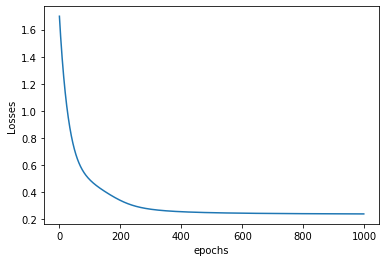

In [91]:
fig, ax = plt.subplots()
_ = plt.plot(history.history['loss'])
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [92]:
# 임베딩 결과
W1 = model.get_weights()[0] # 첫 번째 층의 가중치
b1 = model.get_weights()[1] # 첫 번째 층의 bias

In [93]:
vectors = W1 + b1
print(vectors)

[[ 2.6590095  -2.125996  ]
 [ 1.1518244   1.3135844 ]
 [-0.9255158  -1.8148738 ]
 [ 0.9056039  -1.2620358 ]
 [ 2.150806   -0.31324035]
 [-0.77656615 -2.068821  ]]


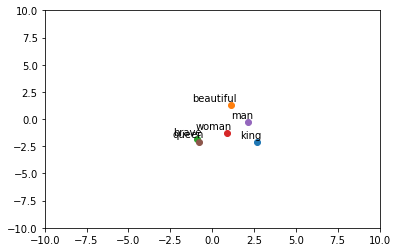

In [94]:
fig, ax = plt.subplots()

#임베딩 그림
for  i, label in enumerate(word_to_int):
    x, y = vectors[i]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
    
plt.show()